# Decode against a 1s preodor baseline period, within a trial type (to see if trial-type decoding is being driven by changes in CS+ representation, CS-, or both)

In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_vs_baseline_vhpc'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'add_significance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_cellreg', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_decoding_combined_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_cross_distinct', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within_beta', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within_subsets', igno

In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [14]:
#all_animals =  'c3f3','c3f2','c3m1', 'c3m2', 'c4m3',         'c10m8', '90', '91', '92','93'
#expo_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
#pre_animals =  'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
#post_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
#renew_animals ='c3f3','c3f2','c3m1', 'c3m2', 'c4m3',         'c10m8', '90', '91', '92','93'
#ext2_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
#ext1_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'

all_animals  = np.loadtxt('../allmice.txt', dtype=str)
expo_animals = np.loadtxt('../expo_mice.txt', dtype=str)
pre_animals  = np.loadtxt('../pre_mice.txt', dtype=str)
d2_animals =  'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
post_animals = np.loadtxt('../post_mice.txt', dtype=str)
renew_animals ='c3f3','c3f2','c3m1', 'c3m2', 'c4m3',         'c10m8', '90', '91', '92','93','91b','92b','93b'
ext2_animals = np.loadtxt('../ext2_mice.txt', dtype=str)
ext1_animals = np.loadtxt('../ext1_mice.txt', dtype=str)

In [15]:
sessions = 'expo', 'pre','d2', 'post','ext1','ext2','renew'

In [16]:
for sess in sessions[1:]:

    exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [17]:
#have to extract expo varibles differently from that used above
patterns_tb_expo = dict(zip(expo_animals,
                                [ut.load_variable('patterns_tb','../%s/2_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

labels_expo = dict(zip(expo_animals,
                                [ut.load_variable('labels','../%s/2_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

In [18]:
delta_t0 = 1

t_start0 = -5  # sec
t_stop0 = 11  # sec

In [7]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)
        
def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict

from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within_beta(patterns_train,patterns_test, labels_train, labels_test, relabel=None, n_cells=None):
    
    if relabel is not None:
        labels_train = np.r_[[relabel[l] for l in labels_train]]
        labels_test = np.r_[[relabel[l] for l in labels_test]]
    else:
        labels_train = labels_train
        labels_test = labels_test
    
    if n_cells is None:
        cells = list(range(patterns_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_train.shape[1]), size=n_cells, replace=False)
    
    decoder.fit(patterns_train[:, cells], labels_train)
    scores = decoder.score(patterns_test[:, cells], labels_test)
    decoder.fit(patterns_test[:, cells], labels_test)
    return np.append(scores, decoder.score(patterns_train[:, cells], labels_train))

In [8]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [9]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [23]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [24]:
for sess in sessions:
    for t in range(16):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue

expo c3f3 expo c3f2 expo c3m1 expo c3m2 expo c4m3 expo c4m4 expo c10m8 expo 90 expo 91 expo 92 expo 93 expo c3f3 expo c3f2 expo c3m1 expo c3m2 expo c4m3 expo c4m4 expo c10m8 expo 90 expo 91 expo 92 expo 93 expo c3f3 expo c3f2 expo c3m1 expo c3m2 expo c4m3 expo c4m4 expo c10m8 expo 90 expo 91 expo 92 expo 93 expo c3f3 expo c3f2 expo c3m1 expo c3m2 expo c4m3 expo c4m4 expo c10m8 expo 90 expo 91 expo 92 expo 93 expo c3f3 expo c3f2 expo c3m1 expo c3m2 expo c4m3 expo c4m4 expo c10m8 expo 90 expo 91 expo 92 expo 93 expo c3f3 expo c3f2 expo c3m1 expo c3m2 expo c4m3 expo c4m4 expo c10m8 expo 90 expo 91 expo 92 expo 93 expo c3f3 expo c3f2 expo c3m1 expo c3m2 expo c4m3 expo c4m4 expo c10m8 expo 90 expo 91 expo 92 expo 93 expo c3f3 expo c3f2 expo c3m1 expo c3m2 expo c4m3 expo c4m4 expo c10m8 expo 90 expo 91 expo 92 expo 93 expo c3f3 expo c3f2 expo c3m1 expo c3m2 expo c4m3 expo c4m4 expo c10m8 expo 90 expo 91 expo 92 expo 93 expo c3f3 expo c3f2 expo c3m1 expo c3m2 expo c4m3 expo c4m4 expo c10m8 ex

### need to take data from a single trial type and duplicate it, assigning it a new label/class. Then use the baseline time bin of the dataset with this new label and decode against all time bins from original dataset

In [25]:
#make a new label array, assigning new labels for each trial type
relabel_baselines = {0:2,1:3}

for sess in sessions:
    exec("labels_baselines_%s = {}"%sess)
    for ani in eval("%s_animals"%sess):
        exec("labels_baselines_%s[ani] = np.r_[[relabel_baselines[l] for l in labels_%s[ani]]]"%(sess,sess))

In [26]:
#concatenate new label array to original
for sess in sessions:
    exec("labels_%s_w_baselines = {}"%sess)
    for ani in eval("labels_%s.keys()"%sess):
        exec("labels_%s_w_baselines[ani] = np.concatenate((labels_%s[ani],labels_baselines_%s[ani]))"%(sess,sess,sess))

In [27]:
# concatenate patterns from one time bin with itself
base = 1 # time bin that will be used as baseline (0 = -5 to -4)
for sess in sessions:
    for t in range(16):
        exec("patterns_tb_%s_%s_w_baselines = {}"%(t,sess))
        for ani in eval("patterns_tb_%s_%s.keys()"%(t,sess)):
            exec("patterns_tb_%s_%s_w_baselines[ani] = np.concatenate((patterns_tb_%s_%s[ani],patterns_tb_%s_%s[ani]))"%(t,sess,t,sess,base,sess))

#### now decode using both labels from a single trial type, reserving one label for the baseline time bin, and the other label for all time bins

In [47]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {0:0,1:-1,2:1,3:-1}
n_loops=15
for t in range(16): # number of time bins
    exec('baseline_scores_tb_%s_CSp = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("baseline_scores_tb_%s_CSp"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(0,4), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 expo 1 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 expo 2 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 expo 3 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 expo 4 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 expo 5 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 expo 6 pre 6 d2 6 post 6 ext1 6 ext2 6 renew 6 expo 7 pre 7 d2 7 post 7 ext1 7 ext2 7 renew 7 expo 8 pre 8 d2 8 post 8 ext1 8 ext2 8 renew 8 expo 9 pre 9 d2 9 post 9 ext1 9 ext2 9 renew 9 expo 10 pre 10 d2 10 post 10 ext1 10 ext2 10 renew 10 expo 11 pre 11 d2 11 post 11 ext1 11 ext2 11 renew 11 expo 12 pre 12 d2 12 post 12 ext1 12 ext2 12 renew 12 expo 13 pre 13 d2 13 post 13 ext1 13 ext2 13 renew 13 expo 14 pre 14 d2 14 post 14 ext1 14 ext2 14 renew 14 expo 15 pre 15 d2 15 post 15 ext1 15 ext2 15 renew 15CPU times: user 3min 54s, sys: 512 ms, total: 3min 54s
Wall time: 3min 54s



In [48]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {0:-1,1:1,2:-1,3:0}
n_loops=15
for t in range(16): # number of time bins
    exec('baseline_scores_tb_%s_CSm = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("baseline_scores_tb_%s_CSm"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(0,4), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 expo 1 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 expo 2 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 expo 3 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 expo 4 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 expo 5 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 expo 6 pre 6 d2 6 post 6 ext1 6 ext2 6 renew 6 expo 7 pre 7 d2 7 post 7 ext1 7 ext2 7 renew 7 expo 8 pre 8 d2 8 post 8 ext1 8 ext2 8 renew 8 expo 9 pre 9 d2 9 post 9 ext1 9 ext2 9 renew 9 expo 10 pre 10 d2 10 post 10 ext1 10 ext2 10 renew 10 expo 11 pre 11 d2 11 post 11 ext1 11 ext2 11 renew 11 expo 12 pre 12 d2 12 post 12 ext1 12 ext2 12 renew 12 expo 13 pre 13 d2 13 post 13 ext1 13 ext2 13 renew 13 expo 14 pre 14 d2 14 post 14 ext1 14 ext2 14 renew 14 expo 15 pre 15 d2 15 post 15 ext1 15 ext2 15 renew 15CPU times: user 3min 53s, sys: 3.3 s, total: 3min 57s
Wall time: 3min 56s



In [49]:
trad_co = ('limegreen','b','r','silver','grey','y')
pal_co = ('#003f5c','#444e86','#955196','#dd5182','#ff6e54','#ffa600')
dark_co = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
dark_co_b = ('forestgreen','darkcyan','rebeccapurple','firebrick','lightgrey','dimgrey','goldenrod')
alt_co = ('hotpink','mediumorchid','darkturquoise','mediumspringgreen','lawngreen','khaki')
session_labels = ('Pre','Early','Late','Ext1','Ext2','Reinstate')
session_labels_b = ('Pre','Early','Day2','Late','Ext1','Ext2','Reinstate')

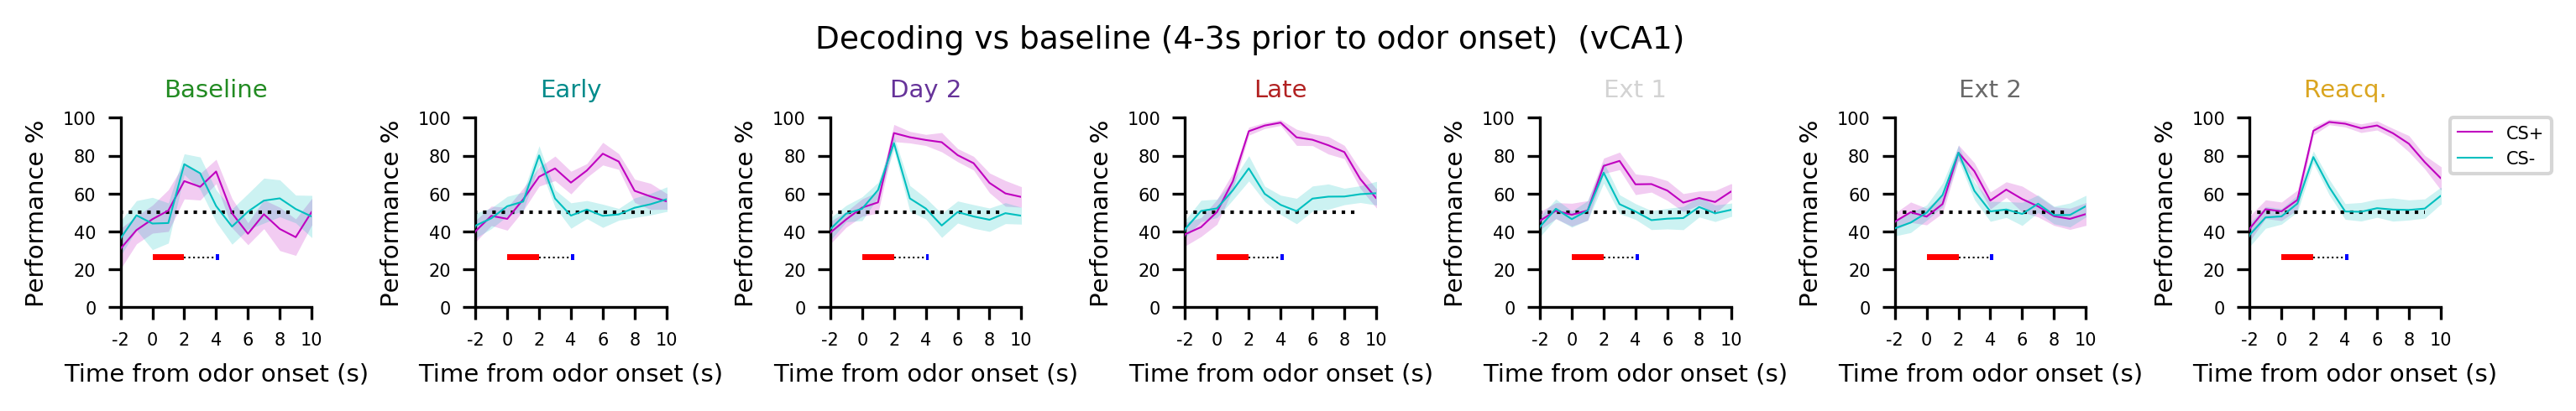

In [49]:
fig, ax = pl.subplots(1,7, figsize=(10, 1.5))

for comp,c,la in zip(['CSp','CSm'],['m','c'],['CS+','CS-']):
    for r,sess in zip(range(len(sessions)),sessions):
        ax[r].plot([(t-4) for t in range(16)], [(np.mean(eval("baseline_scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(16)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(16)])
        s = np.array([np.std(eval("baseline_scores_tb_%s_%s[sess]"%(t,comp)))*100 for t in range(16)])
        ax[r].fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (7):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-2, 9)
    ax[x].set_xticks(np.arange(-2,11, 2))
    ax[x].set_xticklabels(np.arange(-2,11, 2))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co_b[0])
ax[1].set_title('Early', color = dark_co_b[1])
ax[2].set_title('Day 2', color = dark_co_b[2])
ax[3].set_title('Late', color = dark_co_b[3])
ax[4].set_title('Ext 1', color = dark_co_b[4])
ax[5].set_title('Ext 2', color = dark_co_b[5])
ax[6].set_title('Reacq.', color = dark_co_b[6])
ax[6].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (4-3s prior to odor onset)  (vCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

## now decode using minimum number of cells across sessions for eithr dhpc or vhpc (454 cells - vhpc post)

In [55]:
win_min_cells = ut.load_variable('n_cells_within_min_overall', '../notebooks/autorestore/n_cells/')

In [56]:
win_min_cells

454

In [63]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {0:0,1:-1,2:1,3:-1}
n_loops=15
for t in range(16): # number of time bins
    exec('baseline_scores_gmin_tb_%s_CSp = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("baseline_scores_gmin_tb_%s_CSp"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(0,4), n_cells=win_min_cells, relabel=relabel) for i in range(n_loops)]]

expo 0 expo 1 expo 2 expo 3 expo 4 expo 5 expo 6 expo 7 expo 8 expo 9 expo 10 expo 11 expo 12 expo 13 expo 14 expo 15CPU times: user 21.4 s, sys: 44 ms, total: 21.4 s
Wall time: 21.4 s



In [58]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {0:-1,1:1,2:-1,3:0}
n_loops=15
for t in range(16): # number of time bins
    exec('baseline_scores_gmin_tb_%s_CSm = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("baseline_scores_gmin_tb_%s_CSm"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(0,4), n_cells=win_min_cells, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 expo 1 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 expo 2 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 expo 3 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 expo 4 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 expo 5 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 expo 6 pre 6 d2 6 post 6 ext1 6 ext2 6 renew 6 expo 7 pre 7 d2 7 post 7 ext1 7 ext2 7 renew 7 expo 8 pre 8 d2 8 post 8 ext1 8 ext2 8 renew 8 expo 9 pre 9 d2 9 post 9 ext1 9 ext2 9 renew 9 expo 10 pre 10 d2 10 post 10 ext1 10 ext2 10 renew 10 expo 11 pre 11 d2 11 post 11 ext1 11 ext2 11 renew 11 expo 12 pre 12 d2 12 post 12 ext1 12 ext2 12 renew 12 expo 13 pre 13 d2 13 post 13 ext1 13 ext2 13 renew 13 expo 14 pre 14 d2 14 post 14 ext1 14 ext2 14 renew 14 expo 15 pre 15 d2 15 post 15 ext1 15 ext2 15 renew 15CPU times: user 4min 42s, sys: 552 ms, total: 4min 42s
Wall time: 4min 42s



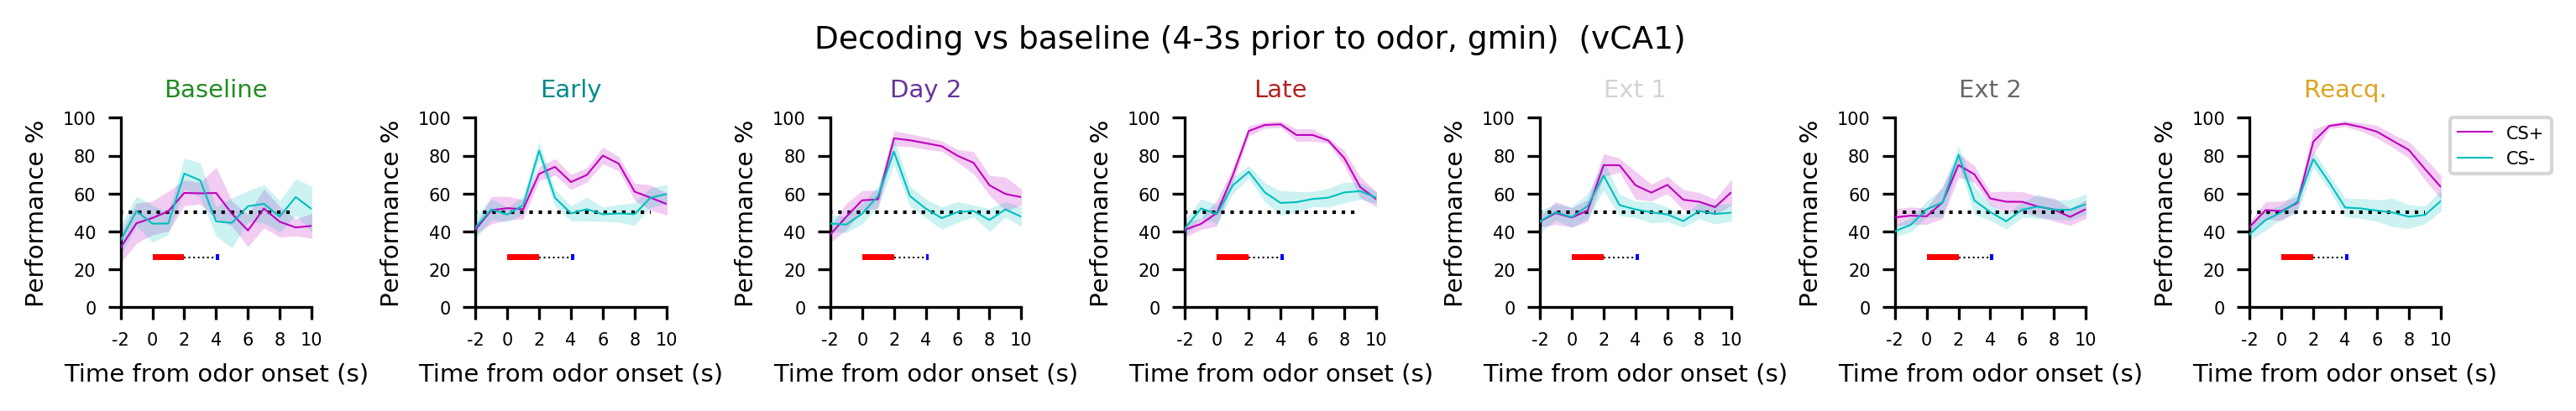

In [65]:
fig, ax = pl.subplots(1,7, figsize=(10, 1.5))
loops=10
for comp,c,la in zip(['CSp','CSm'],['m','c'],['CS+','CS-']):
    for r,sess in zip(range(len(sessions)),sessions):
        ax[r].plot([(t-4) for t in range(16)], [(np.mean(eval("baseline_scores_gmin_tb_%s_%s[sess][:loops]"%(t,comp)))*100) for t in range(16)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_gmin_tb_%s_%s[sess][:loops]"%(t,comp)))*100) for t in range(16)])
        s = np.array([np.std(eval("baseline_scores_gmin_tb_%s_%s[sess][:loops]"%(t,comp)))*100 for t in range(16)])
        ax[r].fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (7):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-2, 9)
    ax[x].set_xticks(np.arange(-2,11, 2))
    ax[x].set_xticklabels(np.arange(-2,11, 2))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co_b[0])
ax[1].set_title('Early', color = dark_co_b[1])
ax[2].set_title('Day 2', color = dark_co_b[2])
ax[3].set_title('Late', color = dark_co_b[3])
ax[4].set_title('Ext 1', color = dark_co_b[4])
ax[5].set_title('Ext 2', color = dark_co_b[5])
ax[6].set_title('Reacq.', color = dark_co_b[6])
ax[6].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (4-3s prior to odor, gmin)  (vCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

## decode using subset of trials

In [176]:
import h5py
def combine_train_test_patterns_subsets(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None, start_trial=None, end_trial=None):
    if classes is None:
        classes = [0, 1, 2, 3]
    which_train = {}
    which_test = {}
    for ani in patterns.keys():        
        which_trains = []
        which_tests = []
        for l in classes:          
            if l>=0:
                if l>=2:
                    if start_trial != None:   #take subset of trials?
                        which_train_aa = np.random.permutation(np.where(labels[ani][start_trial+120:end_trial+120]==l)[0])
                        which_train_a = which_train_aa+start_trial+120
                    else:
                        which_train_a = np.random.permutation(np.where(labels[ani]==l)[0])
                else:
                    if start_trial != None:   #take subset of trials?
                        which_train_aa = np.random.permutation(np.where(labels[ani][start_trial:end_trial]==l)[0])
                        which_train_a = which_train_aa+start_trial
                    else:
                        which_train_a = np.random.permutation(np.where(labels[ani]==l)[0])
                #print which_train_a
                which_tests.append(which_train_a[:len(which_train_a)/2])
                which_trains.append(which_train_a[len(which_train_a)/2:])
        which_train[ani] = np.concatenate(which_trains)
        which_test[ani] = np.concatenate(which_tests)
    #print which_train
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    #print patterns_t.keys()
    #print labels_t
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)


def do_test_within_subsets(patterns, labels,**args):
    x, y, xT, yT = combine_train_test_patterns_subsets(patterns, labels,**args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

In [188]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {0:0,1:-1,2:1,3:-1}
n_loops=10
for t in range(16): # number of time bins
    for phase,trls in zip(['Trials1to30','Trials31to60','Trials61to90','Trials91to120'],[(0,30),(30,60),(60,90),(90,120)]):
        exec('baseline_scores_gmin_tb_%s_%s_CSp = {}'%(t,phase))
        for sess in sessions[1:]:
            print sess,
            print t,
            eval("baseline_scores_gmin_tb_%s_%s_CSp"%(t,phase))[sess] = np.r_[[do_test_within_subsets(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
                eval("labels_%s_w_baselines"%sess),classes=range(0,4), n_cells=win_min_cells, relabel=relabel,start_trial=trls[0],end_trial=trls[1]) for i in range(n_loops)]]

pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 pre 6 d2 6 post 6 ext1 6 ext2 6 renew 6 

st=0
et=30
np.where(labels_pre_w_baselines['90'][st+120:et+120]==3)[0]
which_train_aa = np.random.permutation(np.where(labels_pre_w_baselines['90'][st+120:et+120]==3)[0])
which_train_a = which_train_aa+st+120
print which_train_aa
print which_train_a

In [186]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {0:-1,1:1,2:-1,3:0}
n_loops=10
for t in range(16): # number of time bins
    for phase,trls in zip(['Trials1to30','Trials31to60','Trials61to90','Trials91to120'],[(0,30),(30,60),(60,90),(90,120)]):
        exec('baseline_scores_gmin_tb_%s_%s_CSm = {}'%(t,phase))
        for sess in sessions[1:]:
            print sess,
            print t,
            eval("baseline_scores_gmin_tb_%s_%s_CSm"%(t,phase))[sess] = np.r_[[do_test_within_subsets(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
                eval("labels_%s_w_baselines"%sess),classes=range(0,4), n_cells=win_min_cells, relabel=relabel,start_trial=trls[0],end_trial=trls[1]) for i in range(n_loops)]]

pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 pre 0 d2 0 post 0 ext1 0 ext2 0 renew 0 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 pre 1 d2 1 post 1 ext1 1 ext2 1 renew 1 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 pre 2 d2 2 post 2 ext1 2 ext2 2 renew 2 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 pre 3 d2 3 post 3 ext1 3 ext2 3 renew 3 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 pre 4 d2 4 post 4 ext1 4 ext2 4 renew 4 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 pre 5 d2 5 post 5 ext1 5 ext2 5 renew 5 pre 6 d2 6 post 6 ext1 6 ext2 6 renew 6 

In [ ]:
baseline_scores_gmin_tb_8

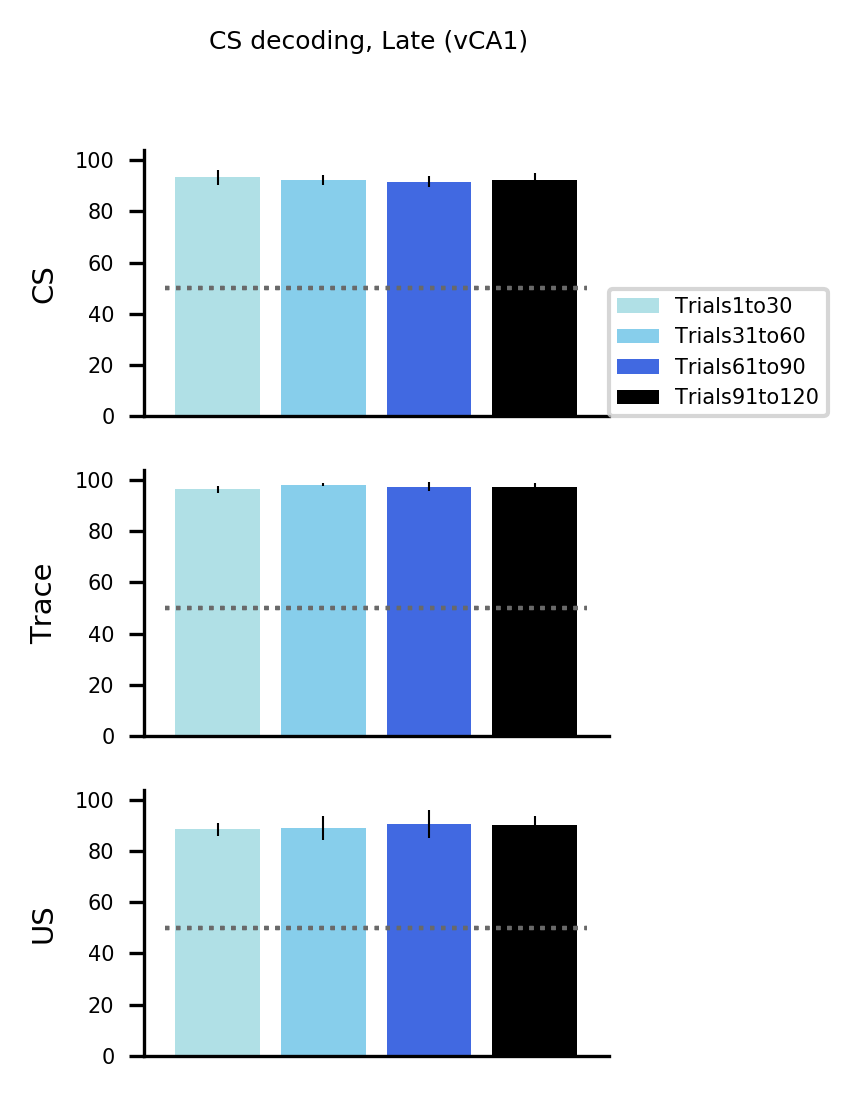

In [189]:
fig,ax = pl.subplots(3,1,figsize=(2,4),sharex=True,sharey=True)

for phase,c,z in zip(['Trials1to30','Trials31to60','Trials61to90','Trials91to120'],(('powderblue','skyblue','royalblue','k')),range(4)):
    for tb,tb_la,r in zip((6,8,10),('CS','Trace','US',),(range(3))):
        s = np.array(np.std(eval("baseline_scores_gmin_tb_%s_%s_CSp['post']"%(tb,phase)))*100)
        ax[r].bar(z, (np.mean(eval("baseline_scores_gmin_tb_%s_%s_CSp['post']"%(tb,phase)))*100), color=c,label=phase,yerr=s)
        ax[r].tick_params(axis='x',bottom=False,labelbottom=False) # labels along the bottom edge are off
        ax[r].set_ylabel(tb_la)
        ax[r].hlines(50, -.5,3.5, color='dimgrey', lw=1, linestyles='dotted')
ax[0].legend(loc=(1,0))
pl.suptitle('CS decoding, Late (vCA1)')
    

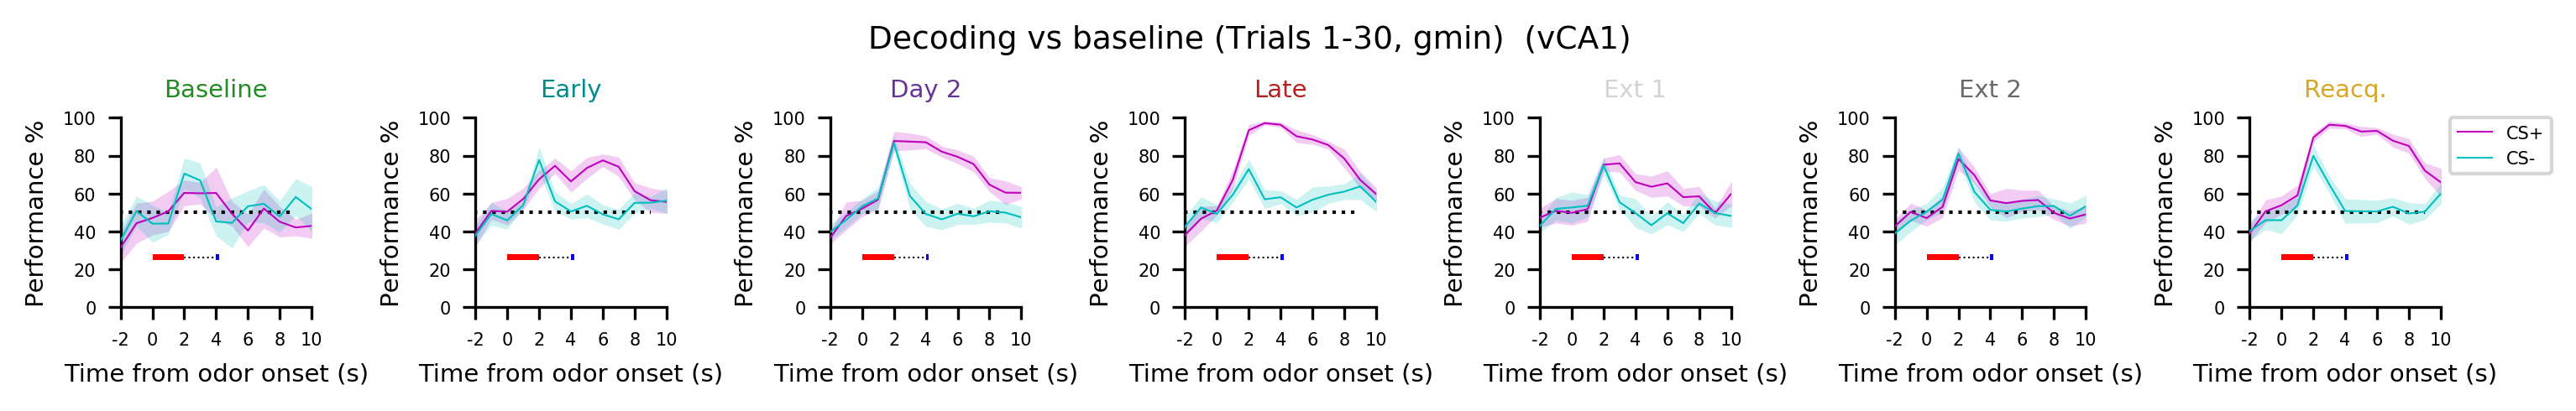

In [190]:
fig, ax = pl.subplots(1,7, figsize=(10, 1.5))
loops=10
for comp,c,la in zip(['CSp','CSm'],['m','c'],['CS+','CS-']):
    for r,sess in zip(range(len(sessions)),sessions):
        if sess == 'expo':
            phase=''
        else:
            phase='_Trials1to30'
        ax[r].plot([(t-4) for t in range(16)], [(np.mean(eval("baseline_scores_gmin_tb_%s%s_%s[sess][:loops]"%(t,phase,comp)))*100) for t in range(16)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_gmin_tb_%s%s_%s[sess][:loops]"%(t,phase,comp)))*100) for t in range(16)])
        s = np.array([np.std(eval("baseline_scores_gmin_tb_%s%s_%s[sess][:loops]"%(t,phase,comp)))*100 for t in range(16)])
        ax[r].fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (7):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-2, 9)
    ax[x].set_xticks(np.arange(-2,11, 2))
    ax[x].set_xticklabels(np.arange(-2,11, 2))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co_b[0])
ax[1].set_title('Early', color = dark_co_b[1])
ax[2].set_title('Day 2', color = dark_co_b[2])
ax[3].set_title('Late', color = dark_co_b[3])
ax[4].set_title('Ext 1', color = dark_co_b[4])
ax[5].set_title('Ext 2', color = dark_co_b[5])
ax[6].set_title('Reacq.', color = dark_co_b[6])
ax[6].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (Trials 1-30, gmin)  (vCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

# And now for decoding across time bins!

In [21]:
#trying to use different trials for different time bins
from sklearn.svm import SVC
decoder = SVC(kernel='linear', decision_function_shape='ovo')

def do_test_cross_distinct(patterns_t,labels_t,patterns_T,labels_T,n_cells=None,classes=None,relabel=None,relabel_test=None,
                          train_test_split=0.5):
    if classes is None:
        classes = [0, 1]
    which_train = {}
    which_test = {}
    for ani in patterns_t.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels_t[ani]==l)[0])
                wT = wt[:int(len(wt)*train_test_split)]
                which_trains.append(wt[int(len(wt)*train_test_split):])
                which_tests.append(wT)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
        #which_train_a = np.random.permutation(np.where(labels_t[ani]==0)[0])
        #which_test_a = which_train_a[:len(which_train_a)/2]
        #which_train_a = which_train_a[len(which_train_a)/2:]
        #
        #which_train_b = np.random.permutation(np.where(labels_t[ani]==1)[0])
        #which_test_b = which_train_b[:len(which_train_b)/2]
        #which_train_b = which_train_b[len(which_train_b)/2:]
        #
        #which_train[ani] = np.concatenate((which_train_a, which_train_b))
        #which_test[ani] = np.concatenate((which_test_a, which_test_b))
    patterns_dt = patterns_t.copy()
    labels_dt = labels_t.copy()
    patterns_dT = patterns_T.copy()
    labels_dT = labels_T.copy()
    for ani in patterns_t.keys():
        patterns_dt[ani] = patterns_dt[ani][which_train[ani]]
        labels_dt[ani] = labels_dt[ani][which_train[ani]]
        patterns_dT[ani] = patterns_dT[ani][which_test[ani]]
        labels_dT[ani] = labels_dT[ani][which_test[ani]]      
        
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_dt, labels_dt, classes=classes)
    patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_dT, labels_dT, classes=classes)
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
        labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
    else:
        labels_comb = labels_comb_
        labels_comb_test = labels_comb_test_
        
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
    
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

## getting reciprocal train and test with function above, but will only extract one way with analysis below

In [24]:
%%time
n_loops=10
relabel = {0:0,1:-1,2:1,3:-1}
for t in range (16):
    for c in range (16):
        exec('baseline_scores_tb_distinct_%s_VS_%s_CSp = {}'%(t,c))
        for sess in sessions:
            print sess,t,c,
            print' ',
            eval('baseline_scores_tb_distinct_%s_VS_%s_CSp'%(t,c))[sess] = np.r_[[do_test_cross_distinct(eval('patterns_tb_%s_%s_w_baselines'%(t,sess)),
                                                                eval("labels_%s_w_baselines"%sess), eval('patterns_tb_%s_%s_w_baselines'%(c,sess)),
                                                                eval("labels_%s_w_baselines"%sess),n_cells=None,classes=range(0,4),
                                                                relabel=relabel) for i in range(n_loops)]]

 expo 0 0   pre 0 0   d2 0 0   post 0 0   ext1 0 0   ext2 0 0   renew 0 0   expo 0 1   pre 0 1   d2 0 1   post 0 1   ext1 0 1   ext2 0 1   renew 0 1   expo 0 2   pre 0 2   d2 0 2   post 0 2   ext1 0 2   ext2 0 2   renew 0 2   expo 0 3   pre 0 3   d2 0 3   post 0 3   ext1 0 3   ext2 0 3   renew 0 3   expo 0 4   pre 0 4   d2 0 4   post 0 4   ext1 0 4   ext2 0 4   renew 0 4   expo 0 5   pre 0 5   d2 0 5   post 0 5   ext1 0 5   ext2 0 5   renew 0 5   expo 0 6   pre 0 6   d2 0 6   post 0 6   ext1 0 6   ext2 0 6   renew 0 6   expo 0 7   pre 0 7   d2 0 7   post 0 7   ext1 0 7   ext2 0 7   renew 0 7   expo 0 8   pre 0 8   d2 0 8   post 0 8   ext1 0 8   ext2 0 8   renew 0 8   expo 0 9   pre 0 9   d2 0 9   post 0 9   ext1 0 9   ext2 0 9   renew 0 9   expo 0 10   pre 0 10   d2 0 10   post 0 10   ext1 0 10   ext2 0 10   renew 0 10   expo 0 11   pre 0 11   d2 0 11   post 0 11   ext1 0 11   ext2 0 11   renew 0 11   expo 0 12   pre 0 12   d2 0 12   post 0 12   ext1 0 12   ext2 0 12   renew 0 12   exp

In [35]:
%%time
n_loops=10
relabel = {0:-1,1:1,2:-1,3:0}
for t in range (16):
    for c in range (16):
        exec('baseline_scores_tb_distinct_%s_VS_%s_CSm = {}'%(t,c))
        for sess in sessions:
            print sess,t,c,
            print' ',
            eval('baseline_scores_tb_distinct_%s_VS_%s_CSm'%(t,c))[sess] = np.r_[[do_test_cross_distinct(eval('patterns_tb_%s_%s_w_baselines'%(t,sess)),
                                                                eval("labels_%s_w_baselines"%sess), eval('patterns_tb_%s_%s_w_baselines'%(c,sess)),
                                                                eval("labels_%s_w_baselines"%sess),n_cells=None,classes=range(0,4),
                                                                relabel=relabel) for i in range(n_loops)]]

expo 0 0   pre 0 0   d2 0 0   post 0 0   ext1 0 0   ext2 0 0   renew 0 0   expo 0 1   pre 0 1   d2 0 1   post 0 1   ext1 0 1   ext2 0 1   renew 0 1   expo 0 2   pre 0 2   d2 0 2   post 0 2   ext1 0 2   ext2 0 2   renew 0 2   expo 0 3   pre 0 3   d2 0 3   post 0 3   ext1 0 3   ext2 0 3   renew 0 3   expo 0 4   pre 0 4   d2 0 4   post 0 4   ext1 0 4   ext2 0 4   renew 0 4   expo 0 5   pre 0 5   d2 0 5   post 0 5   ext1 0 5   ext2 0 5   renew 0 5   expo 0 6   pre 0 6   d2 0 6   post 0 6   ext1 0 6   ext2 0 6   renew 0 6   expo 0 7   pre 0 7   d2 0 7   post 0 7   ext1 0 7   ext2 0 7   renew 0 7   expo 0 8   pre 0 8   d2 0 8   post 0 8   ext1 0 8   ext2 0 8   renew 0 8   expo 0 9   pre 0 9   d2 0 9   post 0 9   ext1 0 9   ext2 0 9   renew 0 9   expo 0 10   pre 0 10   d2 0 10   post 0 10   ext1 0 10   ext2 0 10   renew 0 10   expo 0 11   pre 0 11   d2 0 11   post 0 11   ext1 0 11   ext2 0 11   renew 0 11   expo 0 12   pre 0 12   d2 0 12   post 0 12   ext1 0 12   ext2 0 12   renew 0 12   expo

In [26]:
for t in range (16):
    exec('distinct%s_CSp = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct%s_CSp['%s'] = []"%(t,sess))
        for c in range (16):
            #print eval('testy%s'%t)[sess]
            eval('distinct%s_CSp'%t)[sess].insert(c,(eval('baseline_scores_tb_distinct_%s_VS_%s_CSp'%(t,c))[sess]).mean(0)[0])

In [36]:
for t in range (16):
    exec('distinct%s_CSm = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct%s_CSm['%s'] = []"%(t,sess))
        for c in range (16):
            #print eval('testy%s'%t)[sess]
            eval('distinct%s_CSm'%t)[sess].insert(c,(eval('baseline_scores_tb_distinct_%s_VS_%s_CSm'%(t,c))[sess]).mean(0)[0])

In [29]:
for t in range (16):
    exec('distinct%s_ttest_CSp = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct%s_ttest_CSp['%s'] = []"%(t,sess))
        for c in range (16):
            eval('distinct%s_ttest_CSp'%t)[sess].insert(c,
                (sstats.ttest_1samp(eval('baseline_scores_tb_distinct_%s_VS_%s_CSp[sess][:,0][:10]'%(t,c)),.5)))
        for x,i in zip(eval('distinct%s_ttest_CSp'%t)[sess],range(len(eval('distinct%s_ttest_CSp'%t)[sess]))):
            exec("distinct%s_ttest_CSp[sess][i] = x[-1]"%(t)) #only take p-values

In [37]:
for t in range (16):
    exec('distinct%s_ttest_CSm = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct%s_ttest_CSm['%s'] = []"%(t,sess))
        for c in range (16):
            eval('distinct%s_ttest_CSm'%t)[sess].insert(c,
                (sstats.ttest_1samp(eval('baseline_scores_tb_distinct_%s_VS_%s_CSm[sess][:,0][:10]'%(t,c)),.5)))
        for x,i in zip(eval('distinct%s_ttest_CSm'%t)[sess],range(len(eval('distinct%s_ttest_CSm'%t)[sess]))):
            exec("distinct%s_ttest_CSm[sess][i] = x[-1]"%(t)) #only take p-values

In [30]:
for t in range (16):
    exec('distinct%s_wilcox_CSp = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct%s_wilcox_CSp['%s'] = []"%(t,sess))
        for c in range (16):
            exec("subtracted = [x-0.5 for x in baseline_scores_tb_distinct_%s_VS_%s_CSp[sess][:,0]]"%(t,c))
            eval('distinct%s_wilcox_CSp'%t)[sess].insert(c, sstats.wilcoxon(subtracted[:10]))
        for x,i in zip(eval('distinct%s_wilcox_CSp'%t)[sess],range(len(eval('distinct%s_wilcox_CSp'%t)[sess]))):
            exec("distinct%s_wilcox_CSp[sess][i] = x[-1]"%(t)) #only take p-values

/home/fabios/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [38]:
for t in range (16):
    exec('distinct%s_wilcox_CSm = {}'%t)
for sess in sessions:
    for t in range (16):
        exec("distinct%s_wilcox_CSm['%s'] = []"%(t,sess))
        for c in range (16):
            exec("subtracted = [x-0.5 for x in baseline_scores_tb_distinct_%s_VS_%s_CSm[sess][:,0]]"%(t,c))
            eval('distinct%s_wilcox_CSm'%t)[sess].insert(c, sstats.wilcoxon(subtracted[:10]))
        for x,i in zip(eval('distinct%s_wilcox_CSm'%t)[sess],range(len(eval('distinct%s_wilcox_CSm'%t)[sess]))):
            exec("distinct%s_wilcox_CSm[sess][i] = x[-1]"%(t)) #only take p-values

In [31]:
distinct_CSp={}
for sess in sessions:
    distinct_CSp[sess]=(distinct0_CSp[sess], distinct1_CSp[sess], distinct2_CSp[sess], distinct3_CSp[sess], distinct4_CSp[sess], distinct5_CSp[sess], distinct6_CSp[sess], distinct7_CSp[sess],
                 distinct8_CSp[sess], distinct9_CSp[sess], distinct10_CSp[sess], distinct11_CSp[sess], distinct12_CSp[sess], distinct13_CSp[sess], distinct14_CSp[sess], distinct15_CSp[sess])
    np.array([distinct_CSp[sess]])

In [39]:
distinct_CSm={}
for sess in sessions:
    distinct_CSm[sess]=(distinct0_CSm[sess], distinct1_CSm[sess], distinct2_CSm[sess], distinct3_CSm[sess], distinct4_CSm[sess], distinct5_CSm[sess], distinct6_CSm[sess], distinct7_CSm[sess],
                 distinct8_CSm[sess], distinct9_CSm[sess], distinct10_CSm[sess], distinct11_CSm[sess], distinct12_CSm[sess], distinct13_CSm[sess], distinct14_CSm[sess], distinct15_CSm[sess])
    np.array([distinct_CSm[sess]])

In [40]:
distinct_ttest_CSp={}
for sess in sessions:
    distinct_ttest_CSp[sess]=(distinct0_ttest_CSp[sess], distinct1_ttest_CSp[sess], distinct2_ttest_CSp[sess], distinct3_ttest_CSp[sess],
                          distinct4_ttest_CSp[sess], distinct5_ttest_CSp[sess], distinct6_ttest_CSp[sess], distinct7_ttest_CSp[sess],
                          distinct8_ttest_CSp[sess], distinct9_ttest_CSp[sess], distinct10_ttest_CSp[sess], distinct11_ttest_CSp[sess],
                          distinct12_ttest_CSp[sess], distinct13_ttest_CSp[sess], distinct14_ttest_CSp[sess], distinct15_ttest_CSp[sess])
    np.array([distinct_ttest_CSp[sess]])

In [41]:
distinct_ttest_CSm={}
for sess in sessions:
    distinct_ttest_CSm[sess]=(distinct0_ttest_CSm[sess], distinct1_ttest_CSm[sess], distinct2_ttest_CSm[sess], distinct3_ttest_CSm[sess],
                          distinct4_ttest_CSm[sess], distinct5_ttest_CSm[sess], distinct6_ttest_CSm[sess], distinct7_ttest_CSm[sess],
                          distinct8_ttest_CSm[sess], distinct9_ttest_CSm[sess], distinct10_ttest_CSm[sess], distinct11_ttest_CSm[sess],
                          distinct12_ttest_CSm[sess], distinct13_ttest_CSm[sess], distinct14_ttest_CSm[sess], distinct15_ttest_CSm[sess])
    np.array([distinct_ttest_CSm[sess]])

In [42]:
distinct_wilcox_CSp={}
for sess in sessions:
    distinct_wilcox_CSp[sess]=(distinct0_wilcox_CSp[sess], distinct1_wilcox_CSp[sess], distinct2_wilcox_CSp[sess], distinct3_wilcox_CSp[sess],
                          distinct4_wilcox_CSp[sess], distinct5_wilcox_CSp[sess], distinct6_wilcox_CSp[sess], distinct7_wilcox_CSp[sess],
                          distinct8_wilcox_CSp[sess], distinct9_wilcox_CSp[sess], distinct10_wilcox_CSp[sess], distinct11_wilcox_CSp[sess],
                          distinct12_wilcox_CSp[sess], distinct13_wilcox_CSp[sess], distinct14_wilcox_CSp[sess], distinct15_wilcox_CSp[sess])
    np.array([distinct_wilcox_CSp[sess]])

In [43]:
distinct_wilcox_CSm={}
for sess in sessions:
    distinct_wilcox_CSm[sess]=(distinct0_wilcox_CSm[sess], distinct1_wilcox_CSm[sess], distinct2_wilcox_CSm[sess], distinct3_wilcox_CSm[sess],
                          distinct4_wilcox_CSm[sess], distinct5_wilcox_CSm[sess], distinct6_wilcox_CSm[sess], distinct7_wilcox_CSm[sess],
                          distinct8_wilcox_CSm[sess], distinct9_wilcox_CSm[sess], distinct10_wilcox_CSm[sess], distinct11_wilcox_CSm[sess],
                          distinct12_wilcox_CSm[sess], distinct13_wilcox_CSm[sess], distinct14_wilcox_CSm[sess], distinct15_wilcox_CSm[sess])
    np.array([distinct_wilcox_CSm[sess]])

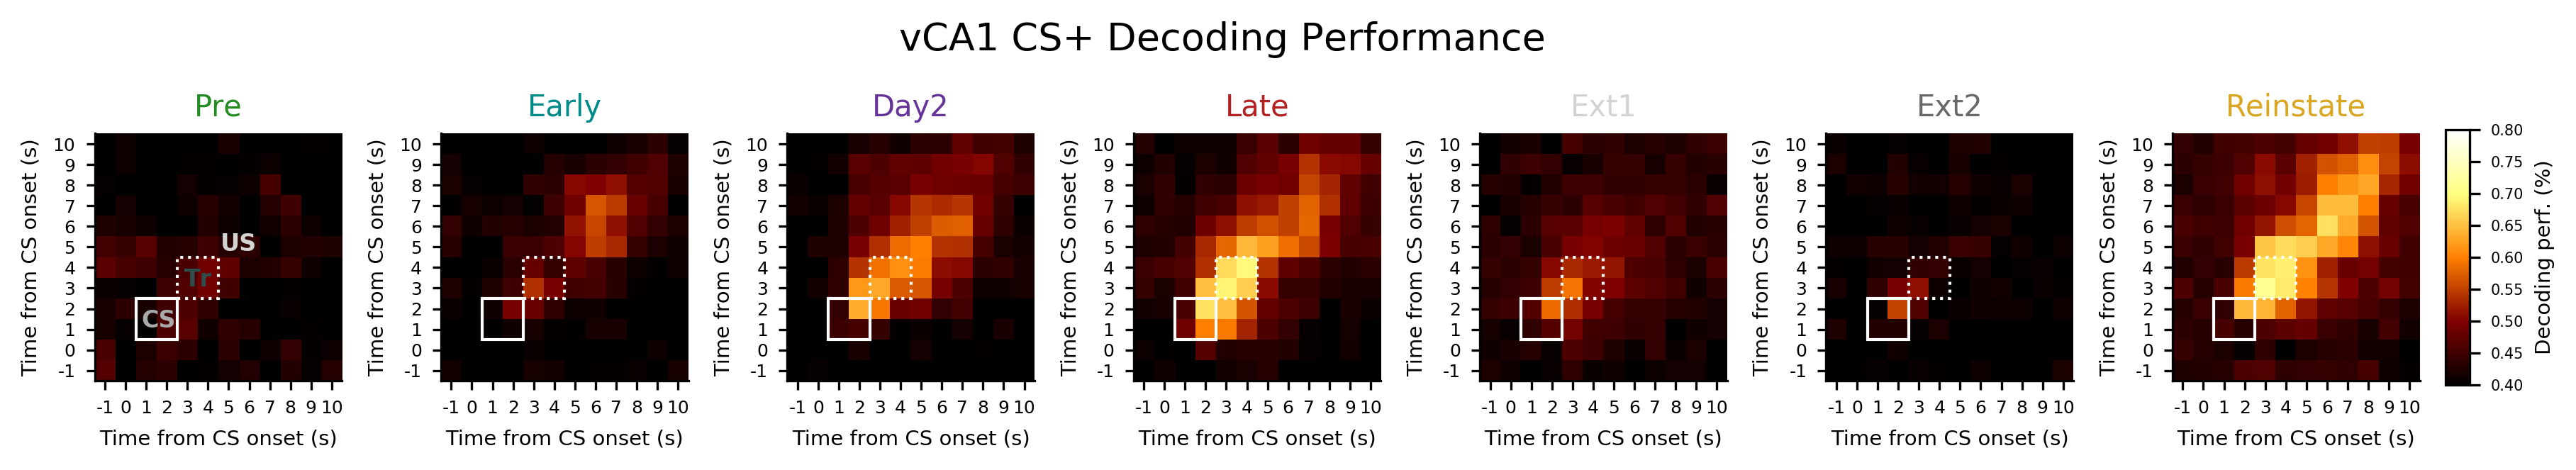

In [34]:
fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)
vmin=0.4
vmax=.8
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_CSp[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (0,7):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 14.5)
    ax[x].set_xlim(2.5,14.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels_b[x],fontsize=10,color=dark_co_b[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='darkgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='darkslategray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('vCA1 CS+ Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

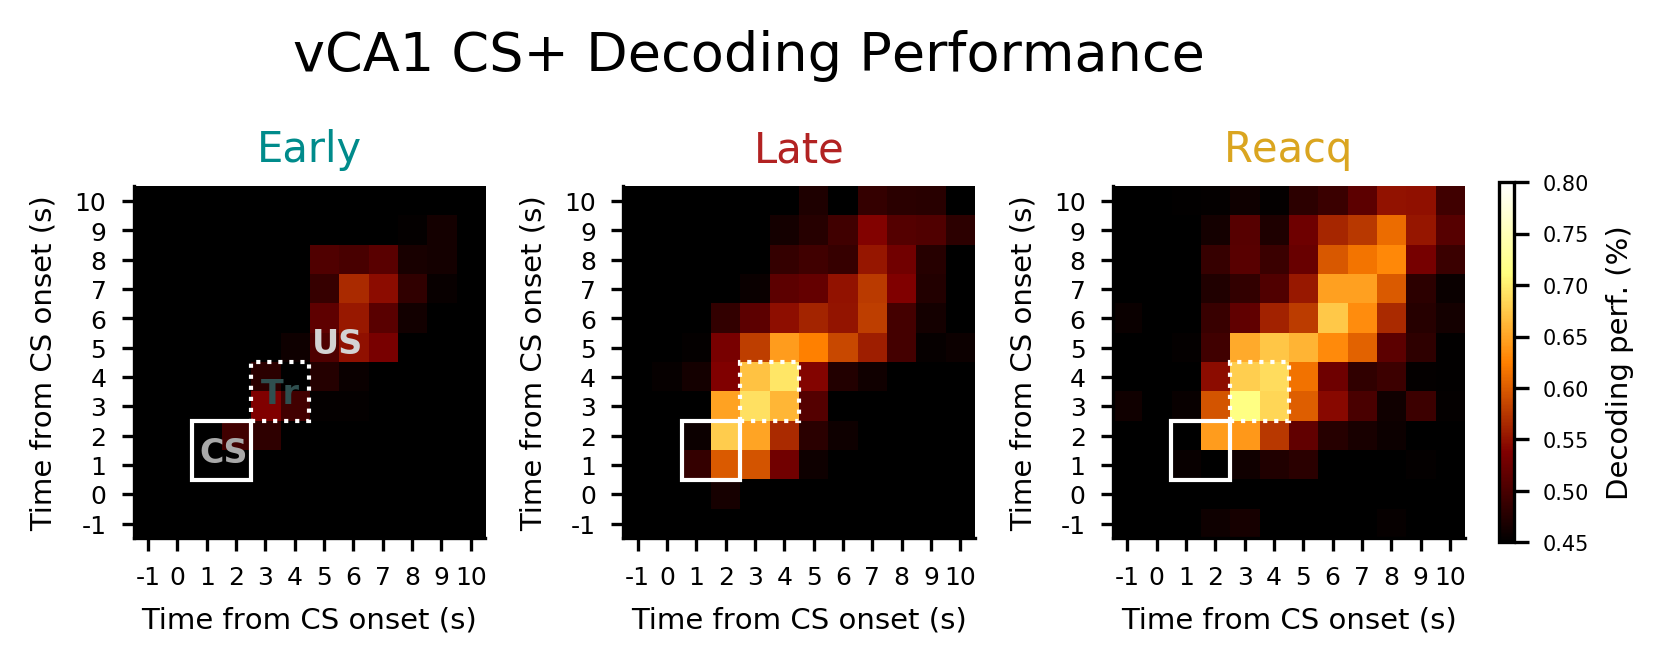

In [209]:
fig, ax = pl.subplots(1, 3, figsize=(5, 3))#, sharex=True, sharey=True)
vmin=0.45
vmax=.8
for sess,x in zip(['pre','post','renew'],range(len(['pre','post','renew']))):
    im = ax[x].imshow(distinct_CSp[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x,la,c in zip(range(3),['Early','Late','Reacq'],['darkcyan','firebrick','goldenrod']):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 14.5)
    ax[x].set_xlim(2.5,14.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(la,fontsize=10,color=c)
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='darkgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='darkslategray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('vCA1 CS+ Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../final-ish figures/%s_across_bins_CS+.pdf'%NOTEBOOK_NAME)

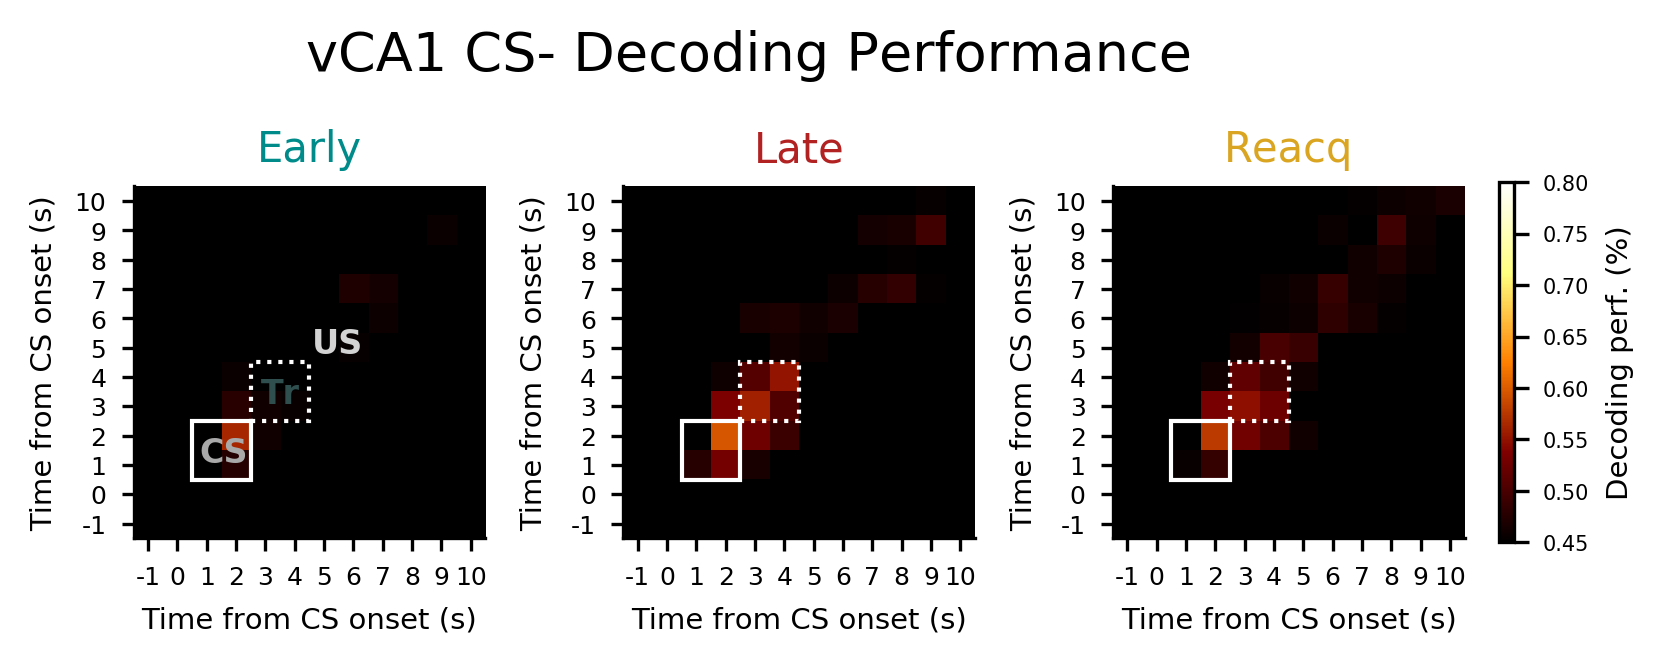

In [210]:
fig, ax = pl.subplots(1, 3, figsize=(5, 3))#, sharex=True, sharey=True)
vmin=0.45
vmax=.8
for sess,x in zip(['pre','post','renew'],range(len(['pre','post','renew']))):
    im = ax[x].imshow(distinct_CSm[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x,la,c in zip(range(3),['Early','Late','Reacq'],['darkcyan','firebrick','goldenrod']):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 14.5)
    ax[x].set_xlim(2.5,14.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(la,fontsize=10,color=c)
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='darkgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='darkslategray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('vCA1 CS- Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../final-ish figures/%s_across_bins_CS-.pdf'%NOTEBOOK_NAME)

### make a array containing all data points for decoding >=2s across time bin


In [211]:
beyond2s_CSp = {}
for sess in sessions:
    beyond2s_CSp[sess] = []
    for tb1 in [6,7,8,9,10]:
        for i in range(3,8):
            if tb1 + i < 15:
                exec("beyond2s_CSp[sess].append(baseline_scores_tb_distinct_%s_VS_%s_CSp[sess])"%(tb1,tb1+i))

In [212]:
beyond2s_CSm = {}
for sess in sessions:
    beyond2s_CSm[sess] = []
    for tb1 in [6,7,8,9,10]:
        for i in range(3,8):
            if tb1 + i < 15:
                exec("beyond2s_CSm[sess].append(baseline_scores_tb_distinct_%s_VS_%s_CSm[sess])"%(tb1,tb1+i))

In [213]:
#take mean of both forward and reverse train-test results
for reg in ['CSp','CSm']:
    exec("beyond2s_all_means_%s = {}"%(reg))
    for sess in sessions:
        exec("beyond2s_all_means_%s[sess] = []"%(reg))
        for x in eval("range(len(beyond2s_%s[sess]))"%reg):
            exec("beyond2s_all_means_%s[sess].append(beyond2s_%s[sess][x].mean(0).mean())"%(reg,reg))

In [214]:
#take mean of forward train-test results
for reg in ['CSp','CSm']:
    exec("beyond2s_forward_means_%s = {}"%(reg))
    for sess in sessions:
        exec("beyond2s_forward_means_%s[sess] = []"%(reg))
        for x in eval("range(len(beyond2s_%s[sess]))"%reg):
            exec("beyond2s_forward_means_%s[sess].append(beyond2s_%s[sess][x].mean(0)[0])"%(reg,reg))

In [215]:
#take mean of reverse train-test results
for reg in ['CSp','CSm']:
    exec("beyond2s_reverse_means_%s = {}"%(reg))
    for sess in sessions:
        exec("beyond2s_reverse_means_%s[sess] = []"%(reg))
        for x in eval("range(len(beyond2s_%s[sess]))"%reg):
            exec("beyond2s_reverse_means_%s[sess].append(beyond2s_%s[sess][x].mean(0)[1])"%(reg,reg))

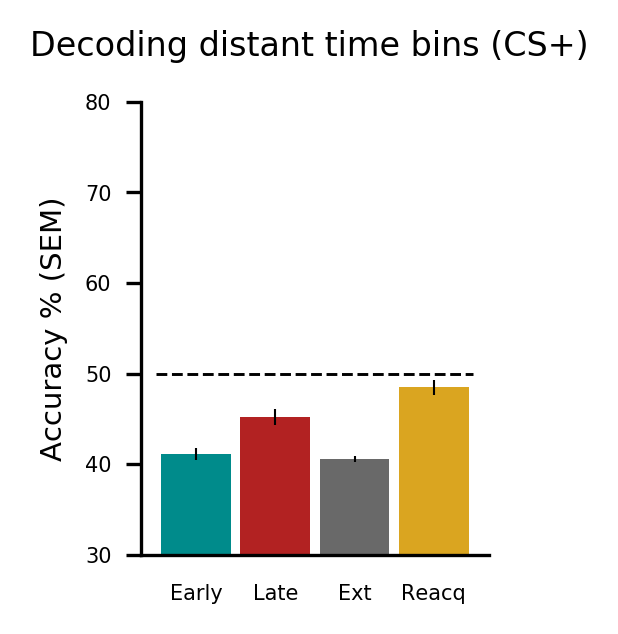

In [216]:
from matplotlib.patches import Patch
labels = 'Early','Late','Ext','Reacq'
x = np.arange(len(labels))  # the label locations
width = 0.88  # the width of the bars
loops = 10
v={}
d={}

fig, ax = pl.subplots(figsize=(1.5,2))
for sess,c,i in zip(['pre','post','ext2','renew'],[1,2,4,-1],range(4)):
    v[sess] = np.array(np.std(beyond2s_all_means_CSp[sess])*100/(np.sqrt(loops-1)))
    ax.bar(i, np.mean(beyond2s_all_means_CSp[sess])*100, width, color=dark_co[c],yerr=v[sess])
ax.hlines(50,-.5,3.5, color='k', lw=.7, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
ax.set_ylim(30,80)
#ax.set_title('Decoding During CS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.legend([Patch(facecolor='k'),Patch(facecolor='whitesmoke',edgecolor='k')],['vCA1','dCA1'],loc=(1,.8),frameon=False)
ax.tick_params(axis='x',bottom=False)
pvs=[]
#for sess,c,i in zip(['pre','post','ext2','renew'],[1,3,4,6],range(4)):
    #pvs.append(sig_vs_chance(ax,beyond2s_all_means_CSp[sess],.5,i,
    #           np.mean(beyond2s_all_means_CSp[sess])*100+v[sess]+1,loops=loops,sig_func=None,colors='k'))
#for i in range(3):
#    pvs.append(add_significance(ax, beyond2s_all_means_CSp[PrPoExRe_sessions[i]],
#                                beyond2s_all_means_CSp[PrPoExRe_sessions[i+1]],i,.95+i,66,mcc=3))
#for i in range(2):
#    pvs.append(add_significance(ax, beyond2s_all_means_CSp[PrPoExRe_sessions[i]],
#                                beyond2s_all_means_CSp[PrPoExRe_sessions[i+2]],i,i+1.95,69+i*3.5,mcc=3))
#pvs.append(add_significance(ax, beyond2s_all_means_CSp[PrPoExRe_sessions[0]],
#                                beyond2s_all_means_CSp[PrPoExRe_sessions[3]],0,2.95,75,mcc=3))
pl.suptitle('Decoding distant time bins (CS+)',y=1,fontsize=8)

#fig.savefig('../final-ish figures/%s_decoding_distant_tbs_all.pdf'%NOTEBOOK_NAME)

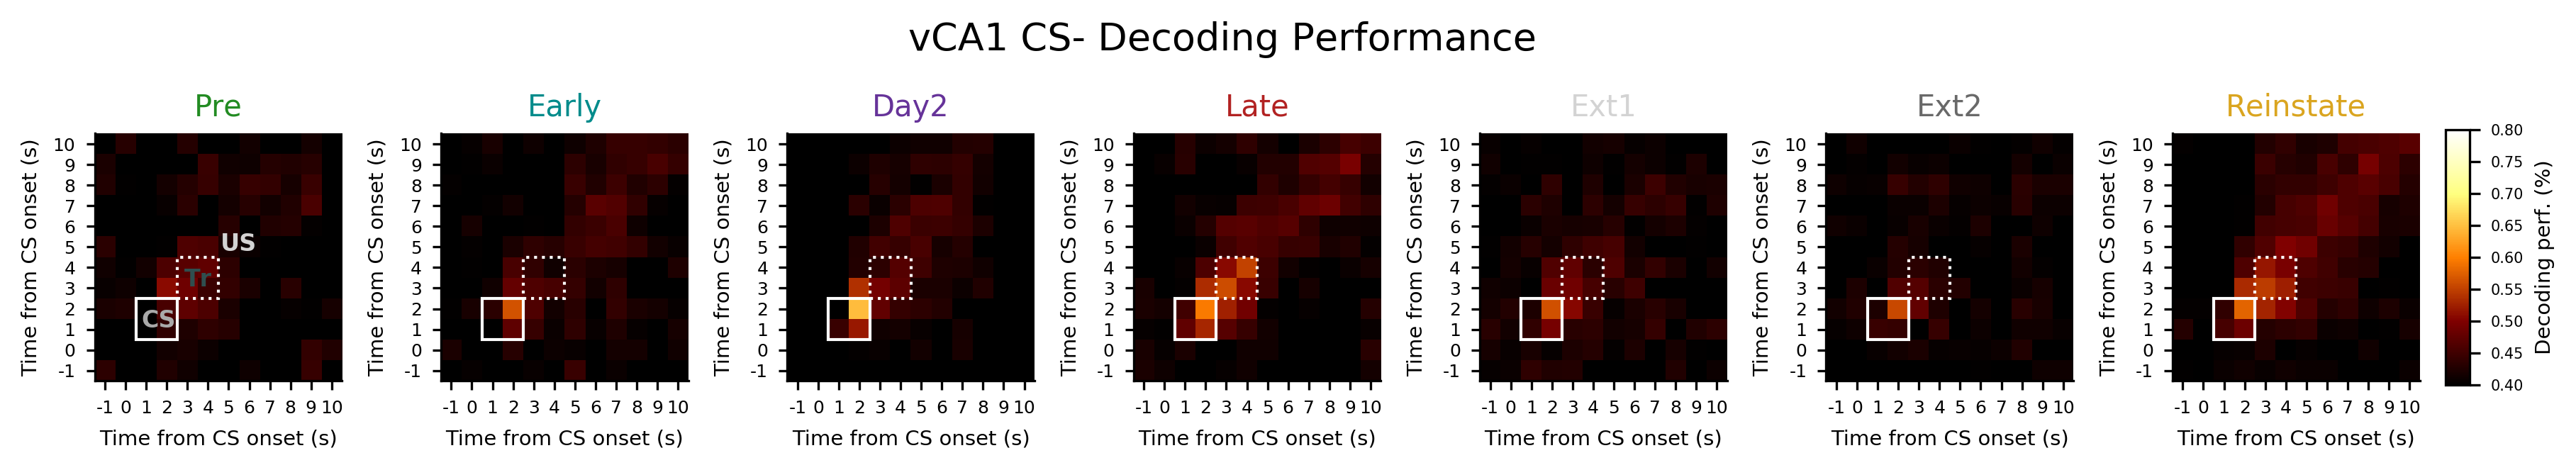

In [47]:
fig, ax = pl.subplots(1, 7, figsize=(11.5, 3))#, sharex=True, sharey=True)
vmin=0.4
vmax=.8
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_CSm[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (0,7):
    ax[x].set_xticks(range(16))
    ax[x].set_yticks(range(16))
    ax[x].set_ylim(2.5, 14.5)
    ax[x].set_xlim(2.5,14.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels_b[x],fontsize=10,color=dark_co_b[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(7):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='darkgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='darkslategray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('vCA1 CS- Decoding Performance',y=.87,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

In [191]:
save_workspace(db)

Could not store variable 'patches'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'CS'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'Tr'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'cax'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'im'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'os'. Skipping...
